AI Explainable

In [1]:
import quantus as q
from torchvision import datasets, transforms
import torch
import random
import numpy as np
#import torch.nn as nn
import torchcomplex.nn.functional as F
import torch.optim as optim
import torchcomplex.nn as cnn
import torch.nn as nn
from torch.utils import data  
import os 
semilla = 0
torch.manual_seed(semilla)
np.random.seed(semilla)
os.listdir()
random.seed(semilla)
from sklearn.metrics import f1_score
from datetime import date
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

In [9]:
data_dir = os.path.join(os.getcwd(),'./Scalograms/') # path of the train images
#test_dir = os.path.join(os.getcwd(),'/home/evida/Documentos/Tesis_Melanoma/Melanoma_thesis_2021/test/') # path of the test images

# Number of classes in the dataset
num_classes = 2

# input size, ???
input_size = 224
# Images transform and normalization
train_t = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        #transforms.RandomResizedCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_t = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# load the dataset
train_set = datasets.ImageFolder(data_dir, train_t)
#test_set = datasets.ImageFolder(test_dir, test_t)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4)

In [2]:
class Mario_NetC3(nn.Module):
    def __init__(self):
        super(Mario_NetC3, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = cnn.Conv2d(3, 48, 5)
        self.conv2 = cnn.Conv2d(48, 24, 3)
        self.conv3 = cnn.Conv2d(24, 32, 3)
        # an affine operation: y = Wx + b
        self.avgpool = cnn.AvgPool2d(kernel_size=(2, 2))
        #self.avgpool2 = cnn.AvgPool2d(kernel_size=(2,2))
        self.fc1 = cnn.Linear(32*2*2650*1, 1200)
        self.fc2 = cnn.Linear(1200, 500)
        # NOTE!  we do not use the Gaussian connections for simplicity.
        self.fc3 = cnn.Linear(500, 2)
    
    # Connect layers, define activation functions
    def forward(self, x):
        # avg pooling over a (2, 2) window
        x = self.conv1(x)
        x = self.avgpool(F.crelu(x))
        # If the size is a square you can only specify a single number
        x = self.conv2(x)
        x = self.conv3(x)
        #print(x.shape)
        #x = self.avgpool2(F.crelu(x))
        # Flat x for fc
        x = x.view(-1, self.num_flat_features(x))
        #print(x.shape)
        x = F.crelu(self.fc1(x))
        x = F.crelu(self.fc2(x))
        x = torch.abs(self.fc3(x))
        #x = np.real(self.fc3(x))
        return x
    
    def num_flat_features(self, x): # To see dimensions of layers
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [4]:
model = Mario_NetC3()
model.load_state_dict(torch.load('best_model_complex_____0.8235294117647058.h5'))

<All keys matched successfully>

In [18]:
x_batch, y_batch = iter(train_loader).next()
x_batch, y_batch = torch.fft.rfft(x_batch), y_batch

In [55]:
import captum
from captum.attr import Saliency, IntegratedGradients

# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1)
a_batch_intgrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, //
                                                       baselines=torch.zeros_like(x_batch)).sum(axis=1)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, y_batch = x_batch, y_batch

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch_saliency, a_batch_intgrad]]

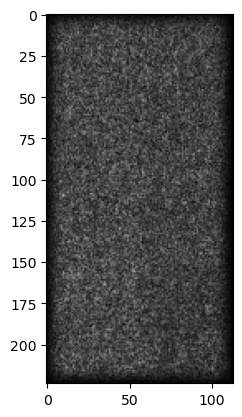

In [76]:
import torchvision
import matplotlib.pyplot as plt
def imshow(img):
    img = img    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images


# show images
imshow(torchvision.utils.make_grid(500.*np.abs(a_batch_saliency[7])))


In [70]:
len(a_batch_saliency)

8